In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [2]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [4]:
data_name = "future_brr_v5"
data_path = "../processed_data/"+data_name+"/"

# Risk Measures
# Variance is automatically included
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall

spot_name = "log return brr"
future_name = "log return future"

paras_results = []
likelihood_results = []
best_h_results = []

calibration_method = "MLE" # MM or MLE
q_arr = [0.05,0.1,0.9,0.95]

ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    # Calibration 
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    for C_name in Copulae:
        Copulae[C_name].Law_RS = kde_brr
        Copulae[C_name].Law_RF = kde_btc
    
    paras = []
    likelihood = []
    best_h = []
    for C_name in Copulae:
        if calibration_method == "MLE":
            Copulae[C_name].canonical_calibrate(u,v)
            
        elif calibration_method == "MM":
            Copulae[C_name].mm_calibrate(u,v,q_arr)

        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    paras_results.append(paras)
    likelihood_results.append(likelihood)
    
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr_ES]
    best_h.index = Copulae_names 
    best_h_results.append(best_h)
    
#     # Testing
#     test = pd.read_csv(data_path+'test/'+file)
#     spot_test   = train.loc[:,spot_name]
#     future_test = train.loc[:,future_name]

Optimization terminated successfully.
         Current function value: -0.418811
         Iterations: 34
         Function evaluations: 72
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.513096
         Iterations: 177
         Function evaluations: 343
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.493901
         Iterations: 143
         Function evaluations: 277
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.389501
         Iterations: 43
         Function evaluations: 91
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.400395
         Iterations: 47
         Function evaluations: 103
Frank is done.

Optimization terminated successfully.
         Current function value: -0.443443
         Iterations: 36
         Function evaluations: 79
Gumbel is done.

Optimization terminated successfully.
        

Optimization terminated successfully.
         Current function value: -0.463464
         Iterations: 89
         Function evaluations: 179
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.353681
         Iterations: 34
         Function evaluations: 74
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.391502
         Iterations: 33
         Function evaluations: 73
Frank is done.

Optimization terminated successfully.
         Current function value: -0.424284
         Iterations: 32
         Function evaluations: 68
Gumbel is done.

Optimization terminated successfully.
         Current function value: -0.457387
         Iterations: 37
         Function evaluations: 89
Plackett is done.

Optimization terminated successfully.
         Current function value: -0.475447
         Iterations: 64
         Function evaluations: 133
Gauss Mix Indep is done.

Optimization terminated successfully.
    

Optimization terminated successfully.
         Current function value: -0.506247
         Iterations: 65
         Function evaluations: 139
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000883
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.045728
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.060842
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.013780
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.002819
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000182
         Iterations: 15
         Function evaluations: 33
Optimi

Optimization terminated successfully.
         Current function value: 0.046090
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.061473
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.013852
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.002937
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000528
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001616
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.061167
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.001374
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.001276
         Iterations: 17
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.001578
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.058483
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.083313
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.015506
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.004565
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.061307
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.086562
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.016825
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.005428
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001589
         Iterations: 16
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000686
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.039981
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.005645
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.002067
         Iterations: 16
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000682
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.040309
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.054639
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.010958
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.001989
         Iterations: 14
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.040312
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.054468
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.010978
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002268
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001048
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.045036
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

In [5]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(paras_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['paras']
    c_arr.append(c)
    
paras_results_pd = pd.concat(dict(zip(ls, c_arr)), axis=1)
paras_results_pd.columns = paras_results_pd.columns.droplevel(1)
paras_results_pd.index.name= None

l_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(likelihood_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['likelihood']
    l_arr.append(c)
    
likelihood_results_pd = pd.concat(dict(zip(ls, l_arr)), axis=1)
likelihood_results_pd.columns = likelihood_results_pd.columns.droplevel(1)
likelihood_results_pd.index.name= None

In [6]:
paras_results_pd

,0.csv,1.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv
Gaussian,{'rho': 0.7674325667695022},{'rho': 0.7594711589848776},{'rho': 0.7564084544789189},{'rho': 0.7572217508939283},{'rho': 0.7609239886158},{'rho': 0.7581751251266962},{'rho': 0.7595967013388873},{'rho': 0.748556852249282}
t_Copula,"{'rho': 0.7752406496218577, 'nu': 2.0220543425...","{'rho': 0.7718866653201444, 'nu': 2.0000000000...","{'rho': 0.7773411437168907, 'nu': 2.0000000000...","{'rho': 0.7773411437168907, 'nu': 2.0000000000...","{'rho': 0.7820289552513064, 'nu': 2.0000000000...","{'rho': 0.7767919348334826, 'nu': 2.0000000000...","{'rho': 0.7791071506253989, 'nu': 2.0000000000...","{'rho': 0.7632052474223798, 'nu': 2.0548954390..."
t_Copula_Capped,"{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7964943393152739, 'nu': 4.0000000000...","{'rho': 0.7982838126804483, 'nu': 4.0000000000...","{'rho': 0.7825919018749863, 'nu': 4.0000000000..."
Clayton,{'theta': 1.8469135166486532},{'theta': 1.8529365876949908},{'theta': 1.866002930513737},{'theta': 1.8937084872912473},{'theta': 1.9591413878323969},{'theta': 1.9465985198689384},{'theta': 1.9466816425323559},{'theta': 1.77680745221752}
Frank,{'theta': 7.189333658802987},{'theta': 7.094186884288493},{'theta': 7.125474902638509},{'theta': 7.0940152086138735},{'theta': 7.209958722816198},{'theta': 7.005343690111864},{'theta': 7.0436581426859135},{'theta': 6.915626809335373}
Gumbel,{'theta': 2.284947163274527},{'theta': 2.2393098094173247},{'theta': 2.2384109596871866},{'theta': 2.233379231843019},{'theta': 2.23842137948667},{'theta': 2.215740427594766},{'theta': 2.2286761519499105},{'theta': 2.1763849617117463}
Plackett,{'theta': 21.022802074651235},{'theta': 20.85156637000094},{'theta': 22.04850462348586},{'theta': 21.89284820924739},{'theta': 22.461832508328992},{'theta': 21.72543013125353},{'theta': 22.082011237740517},{'theta': 20.265601573929022}
Gauss Mix Indep,"{'rho': 0.9104172314227232, 'p': 0.76490483918...","{'rho': 0.9198764839187953, 'p': 0.74035944188...","{'rho': 0.9288720993176496, 'p': 0.72457885005...","{'rho': 0.9279835467468901, 'p': 0.72459120399...","{'rho': 0.9312536904233448, 'p': 0.72415689731...","{'rho': 0.9349260898295535, 'p': 0.70311706637...","{'rho': 0.9353364052078242, 'p': 0.70288329764...","{'rho': 0.9243619196358742, 'p': 0.71303758524..."


In [7]:
likelihood_results_pd

,0.csv,1.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv
Gaussian,0.442836,0.428566,0.423221,0.424634,0.431132,0.426126,0.428621,0.410048
t_Copula,0.516729,0.506200,0.511489,0.512902,0.518207,0.511765,0.515175,0.477768
t_Copula_Capped,0.507484,0.495674,0.497159,0.498280,0.503932,0.495812,0.498999,0.469425
Clayton,0.376095,0.372773,0.373132,0.378149,0.391701,0.388764,0.389500,0.353680
Frank,0.414505,0.405526,0.404340,0.402865,0.411668,0.397362,0.400390,0.391498
Gumbel,0.466937,0.448716,0.446219,0.445325,0.445686,0.439192,0.443443,0.424284
Plackett,0.478391,0.472305,0.479998,0.478245,0.487186,0.473163,0.476817,0.457387
Gauss Mix Indep,0.503609,0.499323,0.508735,0.507469,0.515935,0.506247,0.508469,0.475447


In [ ]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [9]:
def cap(h):
    if h < 0:
        return 0
    elif h >1:
        return 1
    else:
        return h

In [10]:
columns = best_h_results_pd.columns
for c in columns:
     best_h_results_pd.loc[:,c] = best_h_results_pd.loc[:,c].apply(cap)

In [11]:
def hedging_effectiveness(h_arr, spot, future, k_arr, q_arr):
    results = np.ones((len(h_arr),1+len(k_arr)+len(q_arr)))
    for i, h in enumerate(h_arr):
        rh = spot-h*future
        results[i,:]=1-risk_measures(k_arr, q_arr, rh)/risk_measures(k_arr, q_arr, spot)
    return np.array([results[i,i] for i in range(len(h_arr))])

In [12]:
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)

In [13]:
display_likelihood = likelihood_results_pd.copy()
display_likelihood.columns = date_range_arr
display_likelihood = display_likelihood.reindex(sorted(display_likelihood.columns), axis=1)

In [14]:
display_paras = paras_results_pd.copy()
display_paras.columns = date_range_arr
display_paras = display_paras.reindex(sorted(display_paras.columns), axis=1)

In [15]:
display_best_h = best_h_results_pd.copy()
display_best_h.columns.set_levels(date_range_arr, level=0, inplace=True)
display_best_h = display_best_h.reindex(sorted(display_best_h.columns), axis=1)

In [16]:
if os.path.exists("../results/" + data_name)==False:
    print("Create new folder for results")
    os.mkdir("../results/" + data_name)
    os.mkdir("../results/" + data_name +"/MLE")
    os.mkdir("../results/" + data_name +"/MM")
    
if calibration_method == "MLE":
    path = "../results/"+ data_name +"/MLE/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

    
elif calibration_method == "MM":
    path = "../results/"+ data_name +"/MM/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

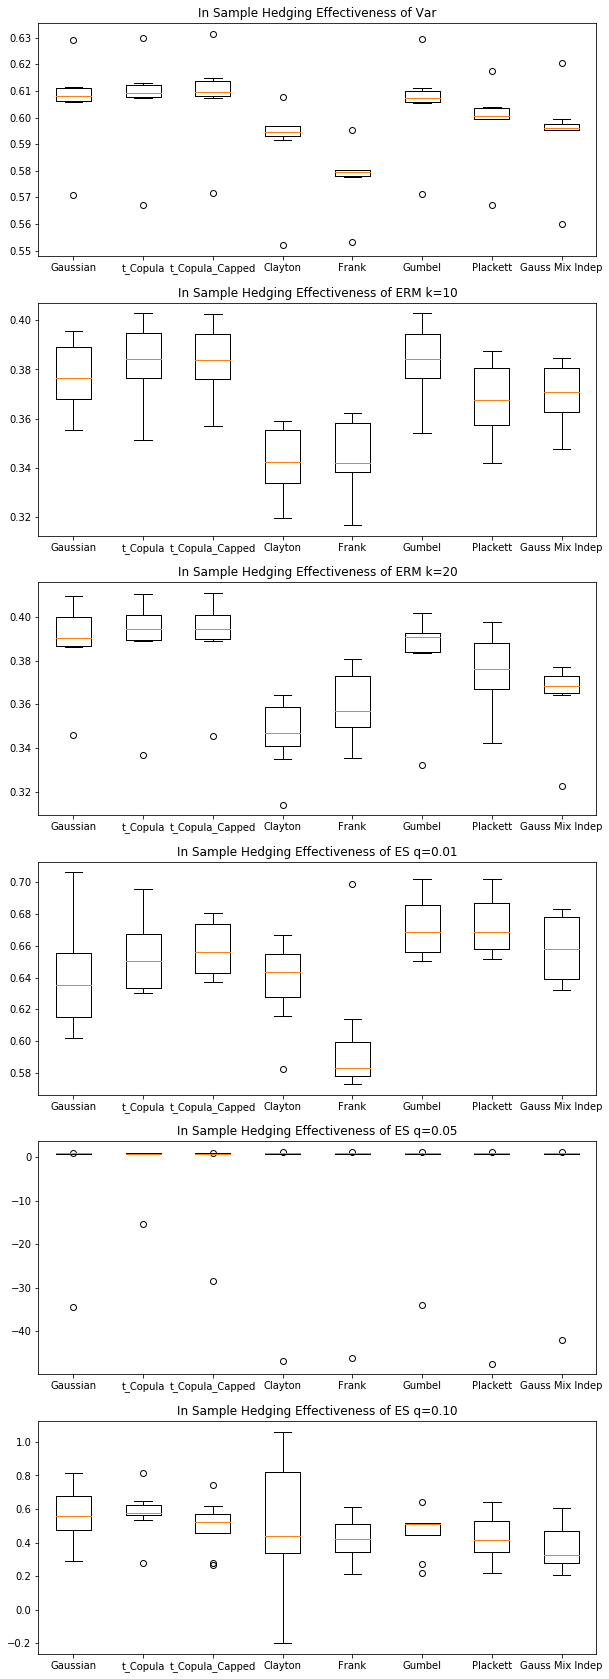

In [17]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("In Sample Hedging Effectiveness of %s"%name)
    
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"In Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"In Sample Hedging Effectiveness.png", transparent=True)

In [ ]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
#     ax[i].set_xticks(np.linspace(1,len(Copulae_names)))
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("Out of Sample Hedging Effectiveness of %s"%name)
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"Out of Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"Out of Sample Hedging Effectiveness.png", transparent=True)

In [ ]:
C1.l_fn()